In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (device)

cuda:0


In [3]:
#load data
train_df = pd.read_excel('train.xlsx')
test_df = pd.read_excel('test.xlsx')

In [4]:
train_cycles = list(set(np.array(train_df['Cycle_Index'])))
test_cycles = list(set(np.array(test_df['Cycle_Index'])))

In [5]:
train_voltage = []
train_current = []
train_temp = []
train_charge_cap = []
train_discharge_cap = []
for i in train_cycles:
    dat = train_df[train_df['Cycle_Index'] == i]
    train_voltage.append(np.array(dat['Voltage(V)']).tolist())
    train_current.append(np.array(dat['Current(A)']).tolist())
    train_temp.append(np.array(dat['Aux_Temperature(℃)_1']).tolist())
    train_charge_cap.append(np.array(dat['Charge_Capacity(Ah)']).tolist())
    train_discharge_cap.append(np.array(dat['Discharge_Capacity(Ah)']))
    
#maximum length of time series is 362, so prepend zeros to make same length
train_data =[]
d1 = []
d2 =[]
d3 =[]
d4 = []
for i in range(0, len(train_cycles)):
    d1 = (list(np.zeros(362-len(train_voltage[i]))) + list(train_voltage[i]))
    d2 = (list(np.zeros(362-len(train_current[i]))) + list(train_current[i]))
    d3 = (list(np.zeros(362-len(train_charge_cap[i]))) + list(train_charge_cap[i]))
    d4 = list(np.zeros(362-len(train_temp[i]))) + list(train_temp[i])
    d = [d1, d2, d3, d4]
    train_data.append(np.transpose(d))
train_data = np.array(train_data)


train_labels = [train_discharge_cap[i][-1] for i in range(0, len(train_discharge_cap))]

In [6]:
print (np.shape(train_data))
#print (train_data)

(171, 362, 4)


In [7]:
test_voltage = []
test_current = []
test_temp = []
test_charge_cap = []
test_discharge_cap = []
for i in test_cycles:
    dat = test_df[test_df['Cycle_Index'] == i]
    test_voltage.append(np.array(dat['Voltage(V)']).tolist())
    test_current.append(np.array(dat['Current(A)']).tolist())
    test_temp.append(np.array(dat['Aux_Temperature(℃)_1']).tolist())
    test_charge_cap.append(np.array(dat['Charge_Capacity(Ah)']).tolist())
    test_discharge_cap.append(np.array(dat['Discharge_Capacity(Ah)']))
    
#maximum length of time series is 362, so prepend zeros to make same length
test_data =[]
d1 = []
d2 =[]
d3 =[]
d4 = []
for i in range(0, len(test_cycles)):
    d1 = (list(np.zeros(362-len(test_voltage[i]))) + list(test_voltage[i]))
    d2 = (list(np.zeros(362-len(test_current[i]))) + list(test_current[i]))
    d3 = (list(np.zeros(362-len(test_charge_cap[i]))) + list(test_charge_cap[i]))
    d4 = list(np.zeros(362-len(test_temp[i]))) + list(test_temp[i])
    d = [d1, d2, d3, d4]
    test_data.append(np.transpose(d))
test_data = np.array(test_data)


test_labels = [test_discharge_cap[i][-1] for i in range(0, len(test_discharge_cap))]

In [8]:
print (np.shape(test_data))

(43, 362, 4)


In [9]:
train_tensor = torch.tensor(train_data)
test_tensor = torch.tensor(test_data)
train_label = torch.tensor(train_labels)
test_label = torch.tensor(test_labels)

In [10]:
train_label = train_label.view(171, 1) 
test_label = test_label.view(43, 1)

In [11]:
print (train_label.shape)
print (test_label.shape)
print(np.shape(train_data))

torch.Size([171, 1])
torch.Size([43, 1])
(171, 362, 4)


In [51]:
#define the LSTM model
class LSTMNet(nn.Module):
    def __init__(self, input_size = 4, seq_len =362, hidden_layer_size = 16, num_layers = 1, output_size = 1, batch_size = 1):
        super(LSTMNet, self).__init__()
        
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first = True)
        
        self.linear1 = nn.Linear(seq_len*hidden_layer_size, 128)
        
        self.linear2 = nn.Linear(128, 64)
        
        self.linear3 = nn.Linear(64, 16)
        
        self.linear4 = nn.Linear(16, 1)
        
        self.hidden_cell = (torch.zeros(num_layers, batch_size , self.hidden_layer_size), 
                            torch.zeros(num_layers, batch_size, self.hidden_layer_size))
        
    def forward(self, x):
        
        lstm_out, self.hidden_cell = self.lstm(x, self.hidden_cell)
        
        lstm_out = lstm_out.reshape(1, -1)
        
        out = self.linear1(lstm_out)
        
        out = self.linear2(out)
        
        out = self.linear3(out)
        
        out = self.linear4(out)
        
        
        return out[-1]


In [47]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [62]:
model = LSTMNet()
criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

In [54]:
print (model)

LSTMNet(
  (lstm): LSTM(4, 16, batch_first=True)
  (linear1): Linear(in_features=5792, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=16, bias=True)
  (linear4): Linear(in_features=16, out_features=1, bias=True)
)


In [63]:
loss_list_train = []
loss_list_test = []
for epoch in range(0, 100):
    loss_list = []
    for i in range(0, len(train_tensor)):
        
        #forward pass
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        output = model(train_tensor[i].unsqueeze(0).float())
        loss = criterion(output, train_label[i])
        loss_list.append(loss.item())
        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list_train.append(sum(loss_list)/len(loss_list))
    
    #prediction
    with torch.no_grad():
        loss_list =[]
        for i in range(0, len(test_tensor)):
            
            test_out = model((test_tensor[i].unsqueeze(0)).float())
            test_loss = criterion(test_out, test_label[i])
            loss_list.append(test_loss.item())
        loss_list_test.append(sum(loss_list)/len(loss_list))
    print (epoch, loss_list_train[-1], loss_list_test[-1])

0 2.258668828428837 2.0310011935788532
1 1.8859710728215893 1.6373879216438116
2 1.4552177448718868 1.1776339231535446
3 0.953324542408101 0.6447467665339626
4 0.4087290784768891 0.1844145419985749
5 0.13001056721335963 0.14448073852893917
6 0.10529708653165583 0.13450955512911775
7 0.09534620820430287 0.12524981276933536
8 0.08907900079649095 0.11645566308221152
9 0.08338423012292873 0.1097571239915005
10 0.07706657696885673 0.11048365470974944
11 0.07707081900702582 0.10515037248300951
12 0.07427535837853862 0.09914682632268862
13 0.07005789056856032 0.09084346405295439
14 0.06548823529516744 0.08487100933873376
15 0.06205662858416462 0.08025609615237214
16 0.058736163970322636 0.07699384800223417
17 0.05676253218399851 0.07255531189053557
18 0.05531669848146494 0.06690026161282561
19 0.05286384116836459 0.06323064205258391
20 0.050728227659972785 0.061163173165432246
21 0.04974774101324249 0.05779755669970845
22 0.04840702550453052 0.05426992094793985
23 0.04770407760352419 0.051278

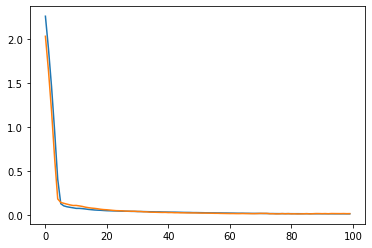

In [64]:
plt.plot(loss_list_train)
plt.plot(loss_list_test)

In [65]:
print(loss_list_test)

[2.0310011935788532, 1.6373879216438116, 1.1776339231535446, 0.6447467665339626, 0.1844145419985749, 0.14448073852893917, 0.13450955512911775, 0.12524981276933536, 0.11645566308221152, 0.1097571239915005, 0.11048365470974944, 0.10515037248300951, 0.09914682632268862, 0.09084346405295439, 0.08487100933873376, 0.08025609615237214, 0.07699384800223417, 0.07255531189053557, 0.06690026161282561, 0.06323064205258391, 0.061163173165432246, 0.05779755669970845, 0.05426992094793985, 0.051278408183607946, 0.05032146254251169, 0.04948478798533595, 0.045842367549275245, 0.0451137991838677, 0.04477617352507835, 0.04426489597143129, 0.04197224628093631, 0.041791364204051884, 0.0382182099098383, 0.03811183918354123, 0.03425188120021377, 0.03362334606259368, 0.03282207943672358, 0.03176638137462527, 0.030977903410445814, 0.03142145899839179, 0.029444101244904274, 0.029832266097845034, 0.02791097829508227, 0.0279356601626374, 0.026661764743716218, 0.0268526132716689, 0.0259406705235326, 0.0254960891812

In [66]:
#evaluate model
model.eval()
with torch.no_grad():
    for i in range(0, len(test_tensor)):
            
        test_out = model((test_tensor[i].unsqueeze(0)).float())
        test_loss = criterion(test_out, test_label[i])
        print(test_label[i], test_out)


tensor([2.1854]) tensor([2.1956])
tensor([2.5116]) tensor([2.4790])
tensor([2.3120]) tensor([2.3395])
tensor([2.3154]) tensor([2.3422])
tensor([2.4350]) tensor([2.4667])
tensor([2.3133]) tensor([2.3406])
tensor([2.0516]) tensor([2.0610])
tensor([2.6355]) tensor([2.6542])
tensor([2.3123]) tensor([2.3299])
tensor([2.3084]) tensor([2.3289])
tensor([2.0539]) tensor([2.0650])
tensor([2.0288]) tensor([2.0358])
tensor([2.0146]) tensor([2.0102])
tensor([2.0023]) tensor([2.0231])
tensor([2.6274]) tensor([2.6402])
tensor([2.3035]) tensor([2.3338])
tensor([1.8940]) tensor([1.8888])
tensor([2.2991]) tensor([2.3194])
tensor([1.8690]) tensor([1.8731])
tensor([2.2934]) tensor([2.3109])
tensor([1.8510]) tensor([1.8471])
tensor([2.2940]) tensor([2.3207])
tensor([2.2310]) tensor([2.3072])
tensor([1.8050]) tensor([1.8193])
tensor([1.7948]) tensor([1.8112])
tensor([2.2739]) tensor([2.2663])
tensor([1.7846]) tensor([1.8145])
tensor([1.7818]) tensor([1.7895])
tensor([2.2775]) tensor([2.2878])
tensor([1.7573

In [67]:
#evaluate model
model.eval()
with torch.no_grad():
    for i in range(0, len(train_tensor)):
            
        train_out = model((train_tensor[i].unsqueeze(0)).float())
        train_loss = criterion(train_out, train_label[i])
        print(train_label[i], train_out[-1])
print (train_loss)


tensor([2.2862]) tensor(2.2638)
tensor([2.2906]) tensor(2.3471)
tensor([2.3079]) tensor(2.3482)
tensor([2.3081]) tensor(2.3407)
tensor([2.3189]) tensor(2.3535)
tensor([2.3150]) tensor(2.3480)
tensor([2.3246]) tensor(2.3556)
tensor([2.3270]) tensor(2.3497)
tensor([2.3241]) tensor(2.3501)
tensor([2.3220]) tensor(2.3530)
tensor([2.3158]) tensor(2.3446)
tensor([2.3217]) tensor(2.3481)
tensor([2.3225]) tensor(2.3551)
tensor([2.3225]) tensor(2.3437)
tensor([2.3321]) tensor(2.3540)
tensor([2.6468]) tensor(2.7344)
tensor([2.3245]) tensor(2.3339)
tensor([2.3194]) tensor(2.3500)
tensor([2.3210]) tensor(2.3503)
tensor([2.3184]) tensor(2.3358)
tensor([2.3203]) tensor(2.3377)
tensor([2.3169]) tensor(2.3402)
tensor([2.3198]) tensor(2.3498)
tensor([2.6437]) tensor(2.6833)
tensor([2.3209]) tensor(2.3494)
tensor([2.3117]) tensor(2.3407)
tensor([2.3193]) tensor(2.3542)
tensor([2.3116]) tensor(2.3472)
tensor([2.6385]) tensor(2.6724)
tensor([2.3202]) tensor(2.3359)
tensor([2.3146]) tensor(2.3262)
tensor([

In [68]:
torch.save(model, "/home/apk/LSTMmodel")

/media/apk/84bd6553-82dd-4faa-9701-e84d64d75ed7/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LSTMNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
torch.save(model.state_dict(), "/home/apk/LSTMmodelstate")

In [71]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            },"/home/apk/LSTMmodelstate_all")